In [1]:
import numpy as np
from numpy import *
import time
import csv
import glob
import os
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords  # Stopwords: ‘the’, ‘is’, ‘are’...
from nltk.stem.porter import * # Stem: gamer, gaming, game -> game
from nltk.tokenize import RegexpTokenizer # Regexp: set rule to just tokenize word
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import NearestNeighbors
import numpy as np

In [2]:
from sklearn.cross_decomposition import PLSRegression

### Load Feature

In [3]:
train_feature, test_feature = [], []

In [4]:
def load_features(path):
    data = []
    with open(path) as f:
        for line in f:
            cols = line.strip().split(',')
            data.append(cols)
    matrix = sorted(data, key=lambda x: int(x[0].split('/')[1].split('.')[0])) # Sort each feature by it's naming order
    matrix = np.array(matrix)[:,1:] # Get rid of the first colum of string
    matrix = matrix.astype(float)
    return matrix

In [5]:
def get_res_feature(filepath):
    feature = np.array(pd.read_csv(filepath, header = None))
    feature_dict = {}
    for i in range(len(feature)):
        id = int(feature[i][0].split("/")[1].split(".")[0])
        feature_dict[id] = np.array(feature[i][1:], dtype=float)
    res = []
    for i in range(len(feature_dict)):
        res.append(feature_dict[i])
    return np.array(res)

In [6]:
train_feature = get_res_feature('./data/features_train/features_resnet1000intermediate_train.csv')
test_feature = get_res_feature('./data/features_test/features_resnet1000intermediate_test.csv')

### Load Description

In [7]:
def load_description(filename):
    raw_description = []
    with open(filename, "r") as f:
        content = f.readlines()
    raw_description = [x.strip() for x in content] 
    return raw_description

In [8]:
def load_all_files(path, fileCount):
    data = []
    for i in range(fileCount):
        filename = path + str(i) + '.txt'
#     for file in glob.glob(os.path.join(path, "*.txt")):
        data.append(load_description(filename))
    return data

In [9]:
raw_descriptions = load_all_files('./data/descriptions_train/', 10000)

In [10]:
test_descriptions = load_all_files('./data/descriptions_test/', 2000)

In [13]:
raw_descriptions[4]

['A young child in the yard holding up a bat.',
 'A boy raring back with a baseball bat in a yard.',
 'A little boy has a baseball bat in a yard.',
 'A boy in black clothes holds a baseball bat over his shoulder near a fence and a tree.',
 'a little boy playing in his yard with a baseball bat']

In [12]:
len(test_descriptions[0])

5

### Load Tag

In [18]:
def get_candidate_tags(path, fileCount):
    vectors = []
    stemmer = PorterStemmer()
    
    for i in range(fileCount):
        filename = path + str(i) + '.txt'
        
        vector = []
        with open(filename, "r") as file_content:
            content = file_content.read()
            for line in content.splitlines():
                for word in line.split(':'):
                    for w in word.split():
                        if w not in stopwords.words('english'):
                            vector.append(stemmer.stem(w))
        vectors.append(" ".join(vector))
    return vectors

In [19]:
training_tags = get_candidate_tags('./data/tags_train/', 10000)

In [295]:
candidate_tags = get_candidate_tags('./data/tags_test/', 2000)

In [298]:
print(training_tags[4])

person person sport basebal bat


### BoW

In [21]:
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             min_df = 20)

In [22]:
def description_to_words(desc, stemmer):
    # Convert to lower case, split into individual words
    words = re.sub('[^\w\s]', ' ', str(desc)).lower().split()                             

    # In Python, searching a set is much faster than searching
    # a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    
    meaningful_words = []
    
    for word in words:
        if word not in stops:
            meaningful_words.append(stemmer.stem(word)) 
            
    return meaningful_words

In [23]:
def descriptions_to_string(descriptions):
    stemmer = PorterStemmer()
    words_set = []
    for desc in descriptions:
        words_set += description_to_words(desc, stemmer)    
    
#     words_set = set(words_set)
    
    # Join the words back into one string separated by space
    return( " ".join(words_set))   

In [24]:
def process_descriptions_with_tag(raw_descriptions, tags):
    print("Processing Descriptions...\n")
    processed_descriptions = []
    num_descriptions = len(raw_descriptions)
    for i in range(num_descriptions):
        if( (i+1)%1000 == 0 ):
            print (str(i+1) + ' of ' + str(num_descriptions))
        words = descriptions_to_string(raw_descriptions[i]) + " " + tags[i]
        processed_descriptions.append(words)
    return processed_descriptions

In [25]:
def process_descriptions(raw_descriptions):
    print("Processing Descriptions...\n")
    processed_descriptions = []
    num_descriptions = len(raw_descriptions)
    for i in range(num_descriptions):
        if( (i+1)%1000 == 0 ):
            print (str(i+1) + ' of ' + str(num_descriptions))
        words = descriptions_to_string(raw_descriptions[i])
        processed_descriptions.append(words)
    return processed_descriptions

In [26]:
def get_BoW(raw_descriptions, tags):
    processed_desc = process_descriptions_with_tag(raw_descriptions, tags)
    print(processed_desc[4])
    desc_BoW = vectorizer.fit_transform(processed_desc)
    desc_BoW = desc_BoW.toarray()
    return desc_BoW

In [27]:
def transform_to_BoW(raw_descriptions):
    processed_desc = process_descriptions(raw_descriptions)
    desc_BoW = vectorizer.transform(processed_desc)
    desc_BoW = desc_BoW.toarray()
    print(len(desc_BoW[0]))
    return desc_BoW

In [28]:
BoW = get_BoW(raw_descriptions, training_tags)

Processing Descriptions...

1000 of 10000
2000 of 10000
3000 of 10000
4000 of 10000
5000 of 10000
6000 of 10000
7000 of 10000
8000 of 10000
9000 of 10000
10000 of 10000
young child yard hold bat boy rare back basebal bat yard littl boy basebal bat yard boy black cloth hold basebal bat shoulder near fenc tree littl boy play yard basebal bat person person sport basebal bat


In [307]:
BoW[1]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [308]:
BoW_binary = [] #np.where(BoW>0, 1, 0)
for line in BoW:
    line_binary = [0] * len(line)
    for i in range(len(line)):
        if line[i] > 0:
            line_binary[i] = 1
        else:
            line_binary[i] = 0
    BoW_binary.append(line_binary)

### Train Model

In [368]:
def get_neural_network_model(X_train, Y_train):
#     clf = MLPRegressor(hidden_layer_sizes=(1000, 1000, 1000))
#     clf = MLPClassifier(hidden_layer_sizes=(1000, 1000, 1000), max_iter=1000, alpha=0.0001, solver='sgd', \
#                    verbose=10, random_state=21, tol=0.000000001)
    clf = PLSRegression(copy=True, max_iter=100000, n_components=1000, scale=True, tol=1e-06)
    clf.fit(X_train, Y_train)
    return clf

In [310]:
NN_model = get_neural_network_model(train_feature, BoW_binary)

Iteration 1, loss = 132.46126714
Iteration 2, loss = 71.77125749
Iteration 3, loss = 66.40106856
Iteration 4, loss = 62.94163737
Iteration 5, loss = 60.68705114
Iteration 6, loss = 59.03790113
Iteration 7, loss = 57.80439747
Iteration 8, loss = 56.81723860
Iteration 9, loss = 56.00542300
Iteration 10, loss = 55.28773924
Iteration 11, loss = 54.68043029
Iteration 12, loss = 54.14457155
Iteration 13, loss = 53.68539717
Iteration 14, loss = 53.22770780
Iteration 15, loss = 52.83904474
Iteration 16, loss = 52.45775722
Iteration 17, loss = 52.11891905
Iteration 18, loss = 51.77953109
Iteration 19, loss = 51.45797279
Iteration 20, loss = 51.17995604
Iteration 21, loss = 50.89524872
Iteration 22, loss = 50.58919466
Iteration 23, loss = 50.35461369
Iteration 24, loss = 50.08773922
Iteration 25, loss = 49.82267287
Iteration 26, loss = 49.56921305
Iteration 27, loss = 49.34849678
Iteration 28, loss = 49.12645848
Iteration 29, loss = 48.91070168
Iteration 30, loss = 48.66217089
Iteration 31, loss

In [369]:
PLS_model = get_neural_network_model(train_feature, BoW_binary)

### Predict Candidate Image

In [445]:
def get_prediction(test_feature):
    prediction_dec = []
    for feature in test_feature:
        prediction = PLS_model.predict(feature.reshape(1, -1))
        prediction_dec.append(prediction[0])
    return prediction_dec

In [446]:
def update_prediction(prediction_dec, candidate_tags):
    updated_prediction = prediction_dec
    tag_BoW = vectorizer.transform(candidate_tags).toarray()
    for i in range(len(prediction_dec)):
        for j in range(len(tag_BoW[i])):
            if tag_BoW[i][j] == 1:
                updated_prediction[i][j] = 1
    return updated_prediction

In [447]:
prediction_dec = get_prediction(test_feature)

In [448]:
updated_prediction = update_prediction(prediction_dec, candidate_tags)

### KNN

In [449]:
test_desc_BoW = transform_to_BoW(test_descriptions)

Processing Descriptions...

1000 of 2000
2000 of 2000
1019


In [450]:
nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(prediction_dec)

In [451]:
result = nbrs.kneighbors(test_desc_BoW)

### Output

In [452]:
def get_timestamp():
    millis = int(round(time.time() * 1000))
    return millis

def create_submission_csv(predictions):
    filename = 'submission' + '_' + str(get_timestamp()) + '.csv'
    with open(filename, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(['Descritpion_ID', 'Top_20_Image_IDs'])
        for i in range (0, len(predictions)):
            description_id = str(i) + ".txt"
            top20_image_ids = " ".join(str(index) + '.jpg' for index in predictions[i])
            writer.writerow([description_id, top20_image_ids])

In [453]:
create_submission_csv(result[1])

In [352]:
from PIL import Image
import matplotlib.pyplot as plt
def show_20_images(top_20, desc_path):
    print ("Desciption: ")
    with open(desc_path, 'r') as f:
        desc = f.read()
        print (desc)
    for i in top_20:
        file = "./data/images_test/" + str(i) + ".jpg"
        print(file)
        img = Image.open(file)
        img = np.asarray(img)
        plt.imshow(img)
        plt.show()

Desciption: 
A group of traffic lights sitting above an intersection.
The sign shining down over the street lights
A picture of a stoplight from a window.
The sun surrounded by an airplane and traffic lights 
Several street lights and an airplane flying overhead.

./data/images_test/0.jpg


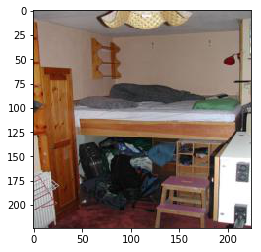

./data/images_test/1193.jpg


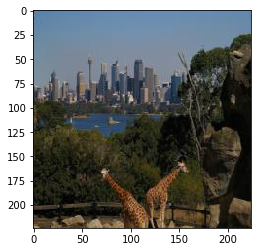

./data/images_test/1192.jpg


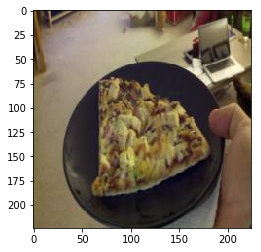

./data/images_test/1190.jpg


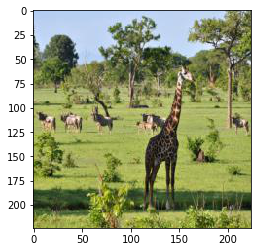

./data/images_test/1189.jpg


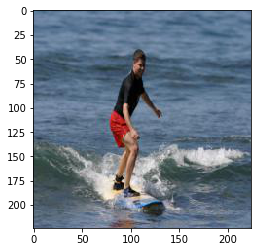

./data/images_test/1186.jpg


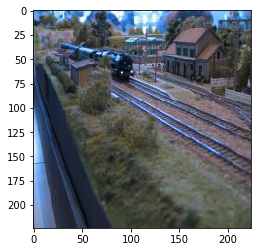

./data/images_test/1182.jpg


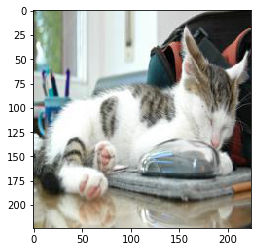

./data/images_test/1181.jpg


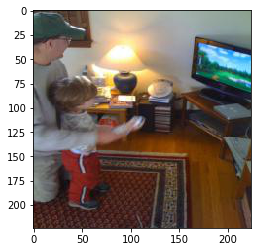

./data/images_test/1180.jpg


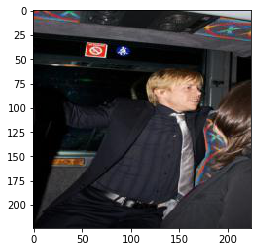

./data/images_test/1177.jpg


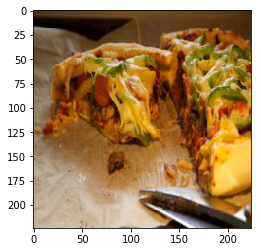

./data/images_test/1176.jpg


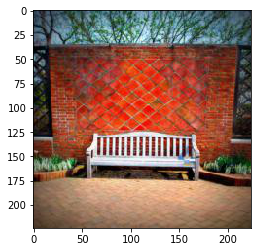

./data/images_test/1173.jpg


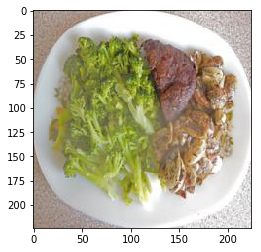

./data/images_test/1171.jpg


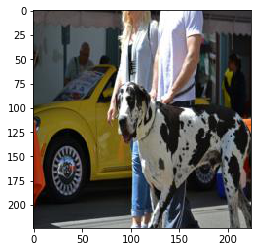

./data/images_test/1170.jpg


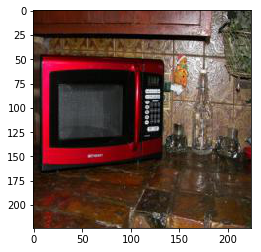

./data/images_test/1169.jpg


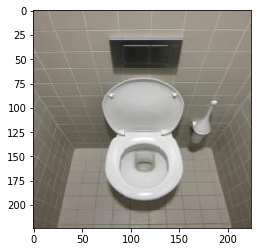

./data/images_test/1167.jpg


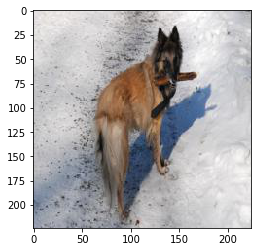

./data/images_test/1164.jpg


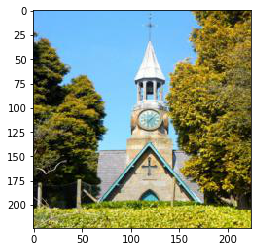

./data/images_test/1162.jpg


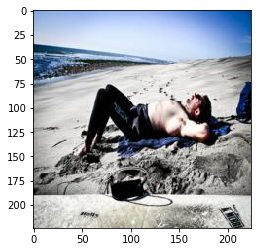

./data/images_test/1160.jpg


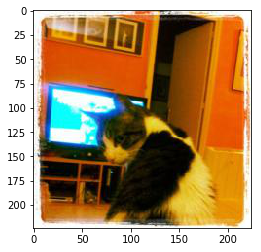

./data/images_test/1159.jpg


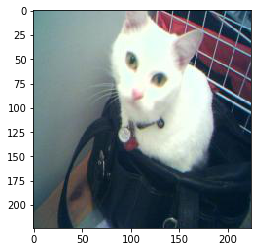

In [356]:
show_20_images(predictions[2], "./data/descriptions_test/2.txt")

In [379]:
def get_top20_indexs(similarities):
    sorted_indexs = np.argsort(similarities)
    return sorted_indexs[:20]

In [380]:
def pairSimil(test, candidate, mode):
    """
    compute the simiarity between one query and 2000 candidates
    base on different mode, we use different way to compute the similarity
    0: cosin
    1: euclidean 
    """
    res = []
    if(mode == 0):
        # use cosin distance
        for n in candidate:
            cos = dot(test,n)/(linalg.norm(test)*linalg.norm(n))
            res.append(cos)
        
    elif(mode == 1):
        # use euclidean distance
        for n in candidate:
            dist = np.linalg.norm(test - n)
            res.append(dist)
    
    res = np.array(res)    
    return res

In [381]:
def get_similarity_array(testing_vectors, candidate_vectors, mode):
    similarity_array = []
    for test in testing_vectors:
        similarity_array.append(pairSimil(test, candidate_vectors, mode))
    return similarity_array

In [382]:
def get_prediction_result(similarity_arrray):
    predictions = []
    for i in range(len(similarity_arrray)):
        predictions.append(get_top20_indexs(similarity_arrray[i]))
    return predictions

In [383]:
similarity_arrray = get_similarity_array(test_desc_BoW, updated_prediction, 0)

In [384]:
predictions = get_prediction_result(similarity_arrray)

In [385]:
create_submission_csv(predictions)

Desciption: 
A group of traffic lights sitting above an intersection.
The sign shining down over the street lights
A picture of a stoplight from a window.
The sun surrounded by an airplane and traffic lights 
Several street lights and an airplane flying overhead.

./data/images_test/598.jpg


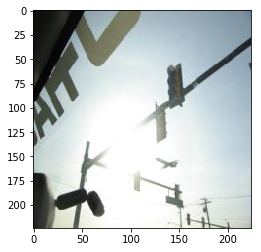

./data/images_test/1840.jpg


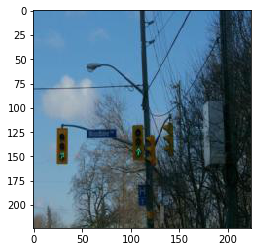

./data/images_test/838.jpg


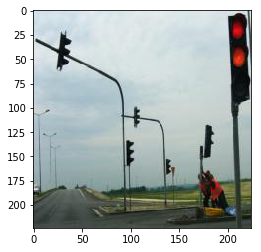

./data/images_test/1471.jpg


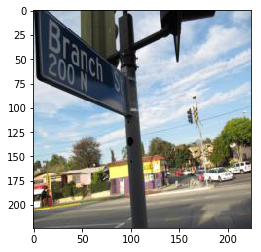

./data/images_test/1665.jpg


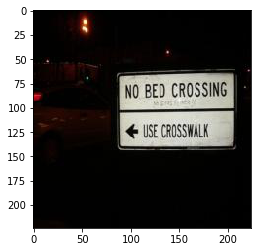

./data/images_test/42.jpg


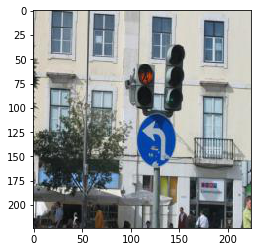

./data/images_test/159.jpg


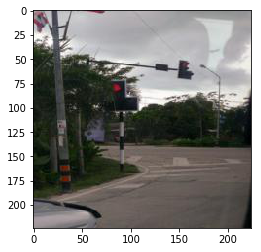

./data/images_test/1366.jpg


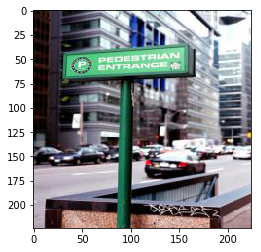

./data/images_test/1183.jpg


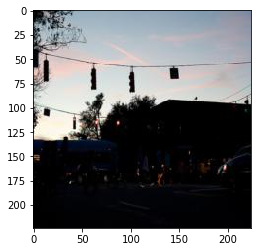

./data/images_test/649.jpg


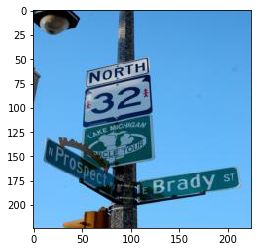

./data/images_test/184.jpg


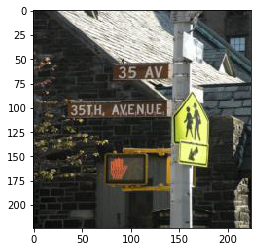

./data/images_test/1724.jpg


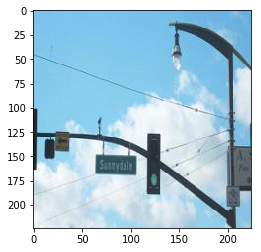

./data/images_test/445.jpg


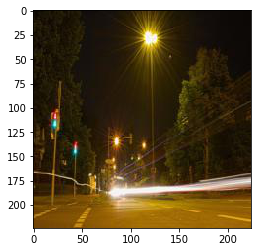

./data/images_test/953.jpg


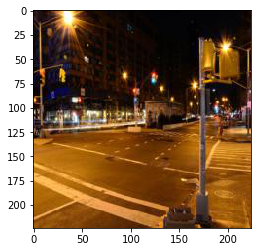

./data/images_test/3.jpg


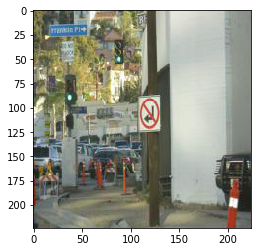

./data/images_test/1866.jpg


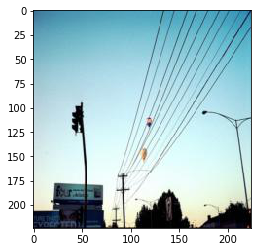

./data/images_test/1124.jpg


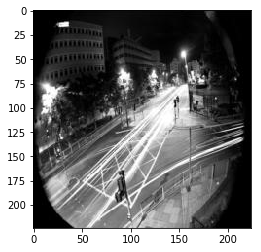

./data/images_test/634.jpg


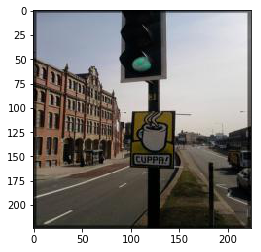

./data/images_test/511.jpg


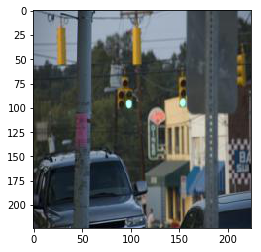

./data/images_test/1107.jpg


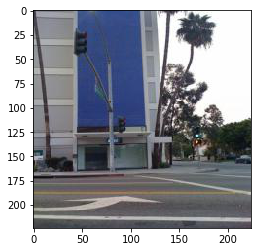

In [387]:
show_20_images(result[1][2], "./data/descriptions_test/2.txt")